# 1- Original data distribution

# Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2

import os

#EDA
import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Label encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

#Data reading
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#CNN
from tensorflow.keras import layers, models, utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
main_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(main_dir, 'train')
valid_dir = os.path.join(main_dir, 'val')
test_dir = os.path.join(main_dir, 'test')

# Prepare folders directories

In [3]:
def folders(dir):
    penumonia = os.path.join(dir, 'PNEUMONIA')
    normal = os.path.join(dir, 'NORMAL')
    return normal, penumonia

In [4]:
normal_train, pneumonia_train = folders(train_dir)
normal_valid, pneumonia_valid = folders(valid_dir)
normal_test,pneumonia_test = folders(test_dir)

In [5]:
img_size = (224, 224)
batch_size = 16

train_data = image_dataset_from_directory(train_dir, image_size = img_size, batch_size = batch_size)
valid_data = image_dataset_from_directory(valid_dir, image_size = img_size, batch_size = batch_size)
test_data = image_dataset_from_directory(test_dir, image_size = img_size, batch_size = batch_size)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [6]:
train_normal = len(os.listdir(normal_train))
train_pneumonia = len(os.listdir(pneumonia_train))

valid_normal = len(os.listdir(normal_valid))
valid_pneumonia = len(os.listdir(pneumonia_valid))

test_normal = len(os.listdir(normal_test))
test_pneumonia = len(os.listdir(pneumonia_test))

# Plot number of images in each directory

In [7]:
print("Number of NORMAL X-Rays in the train dataset =", train_normal)
print("Number of PNEUMONIA X-Rays in the train dataset =", train_pneumonia)
print("-"*60)

print("Number of NORMAL X-Rays in the valid dataset =", valid_normal)
print("Number of PNEUMONIA X-Rays in the valid dataset =", valid_pneumonia)
print("-"*60)

print("Number of NORMAL X-Rays in the test dataset =", test_normal)
print("Number of PNEUMONIA X-Rays in the test dataset =", test_pneumonia)
print("-"*60)


#Plot the nmber of images in each dataset
data = {'Train' : [train_pneumonia, train_normal],
       'Validation' : [valid_pneumonia, valid_normal],
       'Test' : [test_pneumonia, test_normal]}


df = pd.DataFrame(data, index = ['PNEUMONIA', 'NORMAL'])
fig = px.bar(df, x = data, color_discrete_sequence=["darkred", "darkblue", "darkgreen"])

fig.update_layout(title = 'Count of images in Train, Test and Validation sets',
                 xaxis_title = "Count",
                 yaxis_title = "X-Ray result",
                 height = 900, width = 900)
fig.show()

Number of NORMAL X-Rays in the train dataset = 1341
Number of PNEUMONIA X-Rays in the train dataset = 3875
------------------------------------------------------------
Number of NORMAL X-Rays in the valid dataset = 8
Number of PNEUMONIA X-Rays in the valid dataset = 8
------------------------------------------------------------
Number of NORMAL X-Rays in the test dataset = 234
Number of PNEUMONIA X-Rays in the test dataset = 390
------------------------------------------------------------


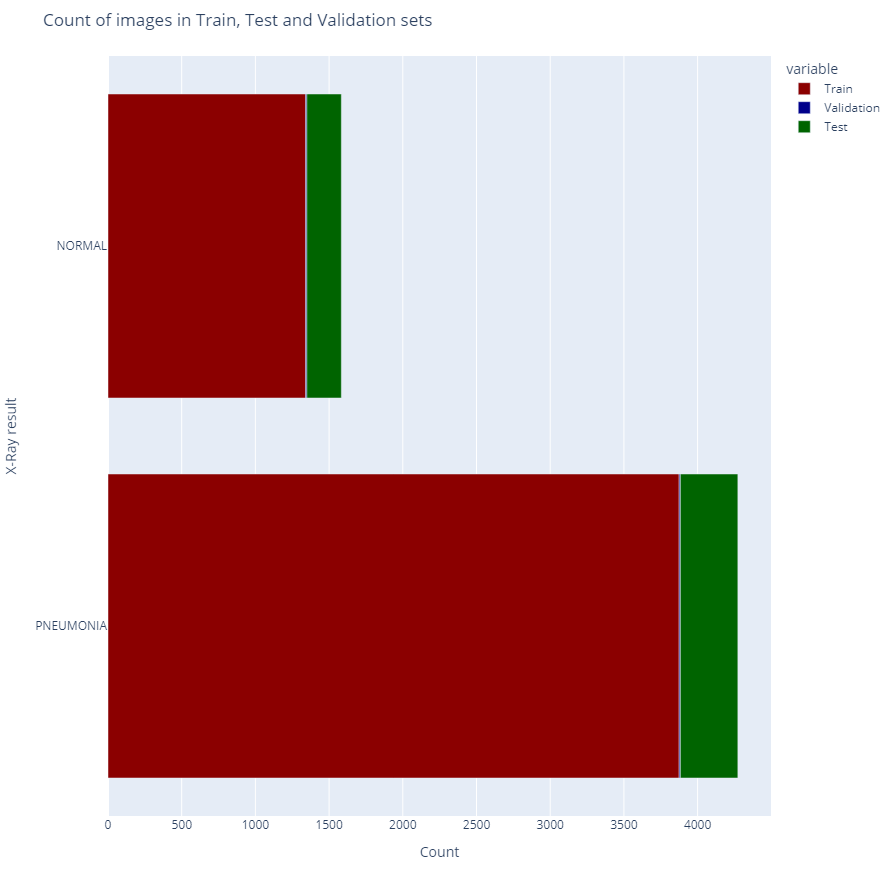

# Explore Datasetmodel.add(Dense(256, activation='relu'))


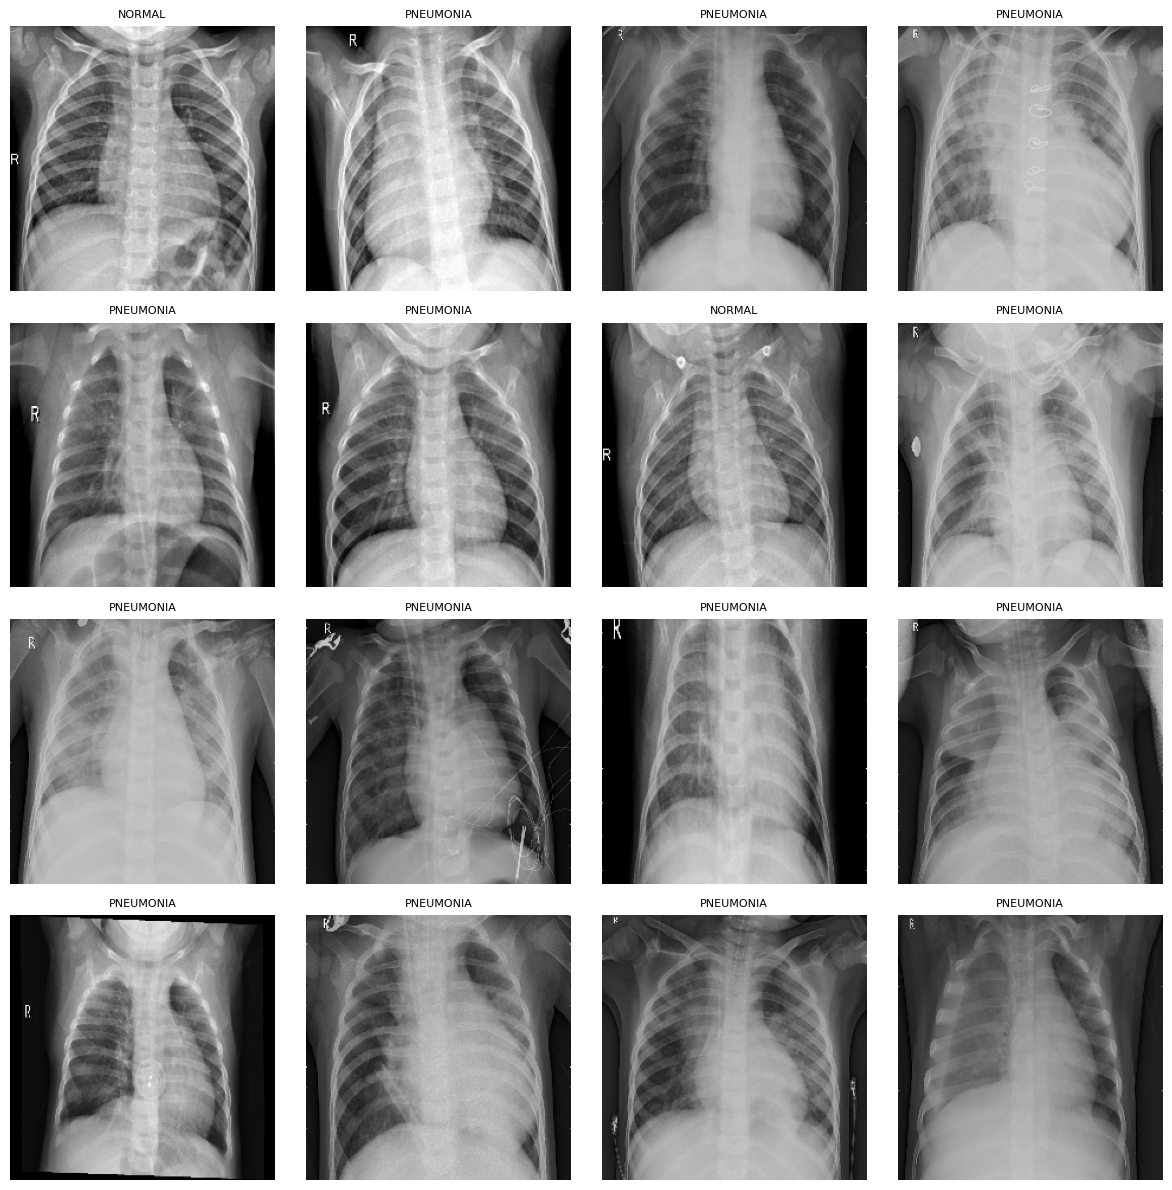

In [8]:
plt.figure(figsize=(12, 12))

for i ,(img, label) in enumerate(train_data):
    for n in range(16):
        plt.subplot(4, 4, n+1)
        plt.imshow(img[n].numpy().astype("uint8"))
        plt.title(train_data.class_names[label[n]], fontsize=8)
        plt.axis("off")
        
plt.tight_layout()
plt.show()

In [9]:
labels = ['NORMAL', 'PNEUMONIA']
def image_preprocessing(data_dir):
    img_list = []
    label_list = []
    
    for label in labels:
        class_dir = os.path.join(data_dir, label) #directory+label -> directory of the class
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name) #class directory + image name -> image name and its class
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) #read as grayscale
            img = cv2.resize(img, (225, 225))
            img = img / 255.0 #normalization
            img_list.append(img)
            label_list.append(label)
            
    return img_list, label_list

In [10]:
train_prep = image_preprocessing(train_dir)
valid_prep = image_preprocessing(valid_dir)
test_prep = image_preprocessing(test_dir)

In [11]:
#check for preprocessed images and labels
print("Number of preprocessed images =", len(train_prep[0]))
print("Number of preprocessed labels =", len(train_prep[1]))
print("-"*40)

print("Number of preprocessed images =", len(valid_prep[0]))
print("Number of preprocessed labels =", len(valid_prep[1]))
print("-"*40)

print("Number of preprocessed images =", len(test_prep[0]))
print("Number of preprocessed labels =", len(test_prep[1]))

Number of preprocessed images = 5216
Number of preprocessed labels = 5216
----------------------------------------
Number of preprocessed images = 16
Number of preprocessed labels = 16
----------------------------------------
Number of preprocessed images = 624
Number of preprocessed labels = 624


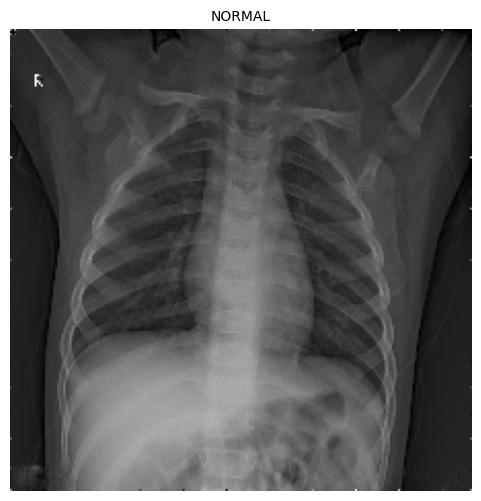

In [12]:
#plot first and last image to check labels are corrct
plt.figure(figsize=(6, 6))
plt.imshow(train_prep[0][0], cmap = 'gray')
plt.title(train_prep[1][0], fontsize=10)
plt.axis("off")
plt.show()

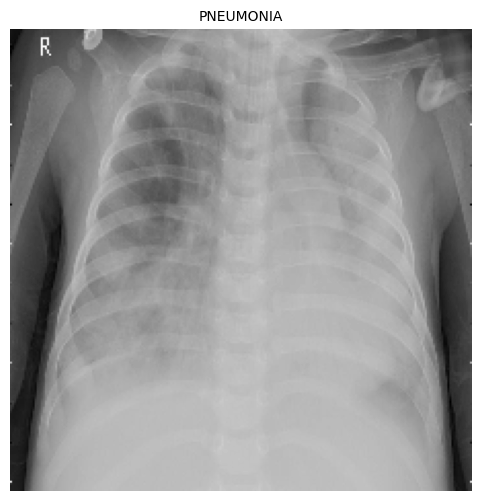

In [13]:
plt.figure(figsize=(6, 6))
plt.imshow(train_prep[0][-1], cmap = 'gray')
plt.title(train_prep[1][-1], fontsize=10)
plt.axis("off")
plt.show()

In [14]:
#convert images to numpy array and reshape them for training
train_imgs = np.array(train_prep[0]).reshape(-1, 225, 225, 1)
valid_imgs = np.array(valid_prep[0]).reshape(-1, 225, 225, 1)
test_imgs = np.array(test_prep[0]).reshape(-1, 225, 225, 1) 

In [15]:
#label encoding
enc = LabelEncoder()

train_enc = enc.fit_transform(train_prep[1])
valid_enc = enc.fit_transform(valid_prep[1])
test_enc = enc.fit_transform(test_prep[1])

In [16]:
train_labels = to_categorical(train_enc, num_classes=2)
valid_labels = to_categorical(valid_enc, num_classes=2)
test_labels = to_categorical(test_enc, num_classes=2)

# Build model

In [81]:
input_shape = (224, 224, 1)
model = Sequential()

#conv b1
model.add(Conv2D(32, kernel_size=(3, 3), strides=1, padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), strides=1, padding='same'))
model.add(MaxPool2D(2, 2)) #reduces to 112x112

#conv b2
model.add(Conv2D(64, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), strides=1, padding='same'))
model.add(MaxPool2D(2, 2)) #reduces to 56x56

#conv b3
model.add(Conv2D(128, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Conv2D(128, kernel_size=(3, 3), strides=1, padding='same'))
model.add(MaxPool2D(2, 2)) #reduces to 28x28
model.add(BatchNormalization())

#conv b4
model.add(Conv2D(256, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Conv2D(256, kernel_size=(3, 3), strides=1, padding='same'))
model.add(MaxPool2D(2, 2)) #reduces to 14x14
model.add(BatchNormalization())

model.add(Conv2D(256, kernel_size=(3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2)) #reduces to 7x7

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 5,017,122 (19.14 MB)

 Trainable params: 5,015,842 (19.13 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [82]:
lr = 1e-3
epochs = 20
batch_size = 8
history = model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.losses.BinaryCrossentropy,
              metrics=['accuracy'])

In [83]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, verbose=2, min_lr=1e-7)

# Model Training

In [84]:
history = model.fit(train_imgs, train_labels, validation_data=(valid_imgs, valid_labels), epochs = epochs
                   ,callbacks = [early_stopping, reduce_lr])

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 136ms/step - accuracy: 0.8529 - loss: 0.4545 - val_accuracy: 0.5000 - val_loss: 40.6747 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.9482 - loss: 0.1341 - val_accuracy: 0.5000 - val_loss: 15.1534 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.9658 - loss: 0.1018 - val_accuracy: 0.5000 - val_loss: 5.1702 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.9718 - loss: 0.0821 - val_accuracy: 0.5625 - val_loss: 2.1301 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.9765 - loss: 0.0709 - val_accuracy: 0.6875 - val_loss: 3.3091 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.9679 - loss: 0.0816 - val_accuracy: 1.0000 - val_loss: 0.1356 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0

# Model Evaluation

In [85]:
loss, acc = model.evaluate(valid_imgs, valid_labels)
print("Validation Loss = ", loss)
print("Validation Accuracy = ", acc*100, "%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9375 - loss: 0.1985
Validation Loss =  0.19846723973751068
Validation Accuracy =  93.75 %


In [86]:
loss, acc = model.evaluate(test_imgs, test_labels)
print("Test Loss = ", loss)
print("Test Accuracy = ", acc*100, "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6657 - loss: 2.3042
Test Loss =  1.270888328552246
Test Accuracy =  81.7307710647583 %


# Learning Curve

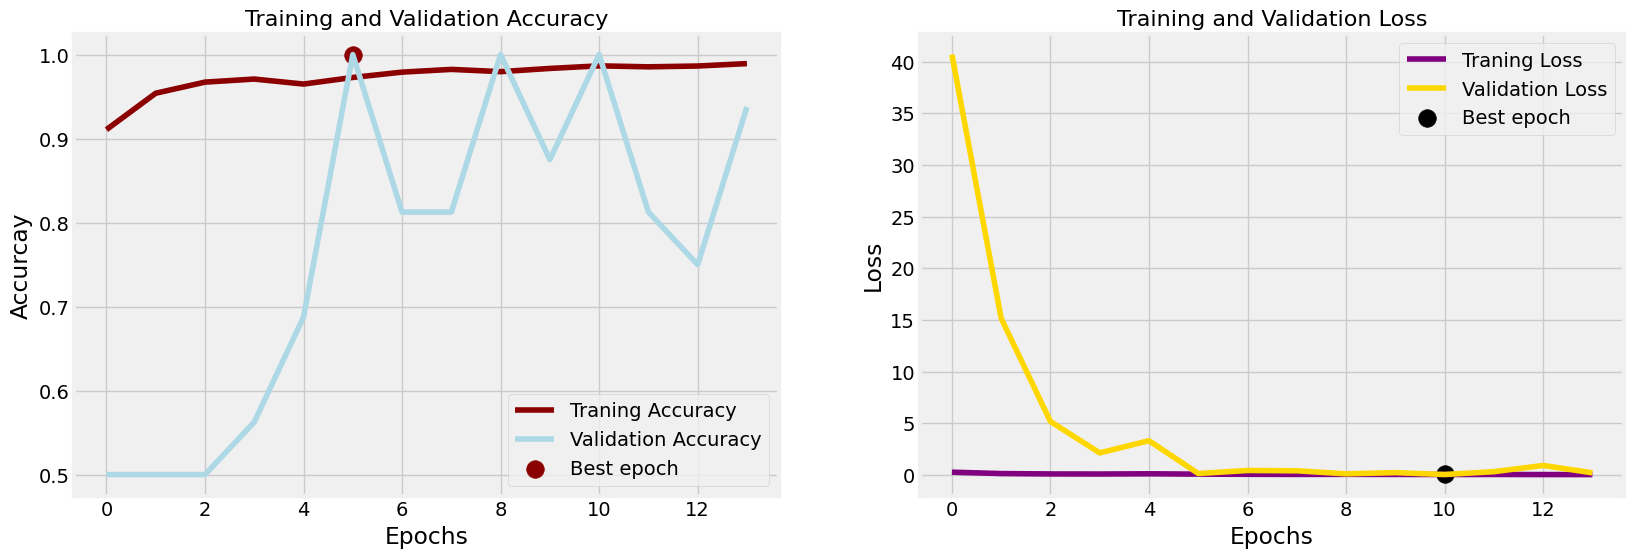

In [87]:
#train history
train_acc = history.history['accuracy']
train_loss = history.history['loss']

#validatioin history
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

min_loss = np.argmin(val_loss) # get min val loss epoch #
val_lowest = val_loss[min_loss]

max_acc = np.argmax(val_acc) #get max val acc epoch #
val_max = val_acc[max_acc]

epochs_ = [i for i in range(len(train_acc))]

#Plot Style
plt.figure(figsize = (20,6))
plt.style.use('fivethirtyeight')

#Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_, train_acc, 'darkred', label = "Traning Accuracy")
plt.plot(epochs_, val_acc, 'lightblue', label = "Validation Accuracy")
plt.scatter(max_acc, val_max, s = 160, c = "darkred", label = "Best epoch")

plt.title("Training and Validation Accuracy", fontsize = 16)
plt.xlabel("Epochs")
plt.ylabel("Accurcay")
plt.legend()

#Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_, train_loss, 'purple', label = "Traning Loss")
plt.plot(epochs_, val_loss, 'gold', label = "Validation Loss")
plt.scatter(min_loss, val_lowest, s = 160, c = "black", label = "Best epoch")

plt.title("Training and Validation Loss", fontsize = 16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [88]:
preds = model.predict(test_imgs)
label_preds = np.argmax(preds, axis = 1)
true_labels = np.argmax(test_labels, axis = 1)
cr = classification_report(true_labels, label_preds, target_names=['NORMAL', 'PNEUMONIA'])
print(cr)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
              precision    recall  f1-score   support

      NORMAL       0.98      0.53      0.68       234
   PNEUMONIA       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.88      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624



# Confusion Matrix

<Figure size 1000x1000 with 0 Axes>

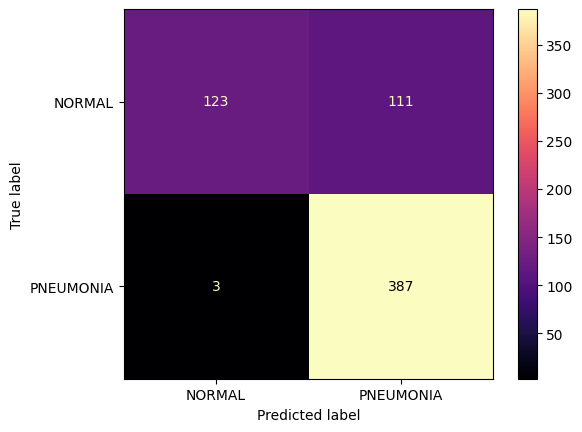

In [89]:
plt.style.use('default')
cm = confusion_matrix(true_labels, label_preds)
disp_cm = ConfusionMatrixDisplay(cm, display_labels=labels)
plt.figure(figsize=(10, 10))
disp_cm.plot(cmap='magma')
plt.show()

## Result Analysis
### 1- Normal Class:
- 0.98 Precision: The model predicts **Normal** class correctly `98%` of the time so the model is highly accurate when it predicts normal X-Rays meaning there is fewer False Positives
- 0.53 recall: Indicates that the model correctly identifies only `53%` of the **actual Normal** X-Rays so it misses a large number of the normal X-Rays

### 2- Pneumonia Class:
- 0.78 Precision: The model has relatively more False Positives, and `78%` of the time, predicts **Pneumonia** X-Rays correctly
- 0.99 Recall: Indicates that the model correctly identifies `99%` actual Pnuemonia X-Rays which means the model is good at identifying the **Pneumonia** X-Rays and misses only a few

## Implications of the model's accuracy:
### 1- Data Imbalance:
- The data is highly imbalanced, it has way more images of` Pneumonia X-Rays` which could lead to overfitting
- It leads to the model predicting **Pnuemonia** classes very well while struggling with predicting **Normal** X-Rays

### 2- High Precision and Low Recall for **Normal** Class:
- The model is very confident while predicting **Normal** Class, therefore the Precision score is `0.98`
- The model struggles to predict **Normal** X-Rays as it predicts only `53%` of the actual Normal cases

### 3- High Recall and low Precision for **Pneumonia class**:
- The model not as confident confident while predicting **Pneumonia** Class, therefore the Precision score is `0.78`
- The model does a very good job predicting **Pneumonia** X-Rays as it predicts only `53%` of the actual Pneumonia cases

### 4- Impact on medical use:
- The **low recall** score in the Normal class would lead to **misdiagnosis** for many healthy patients and possible mistreatment
- The **high recall** score in the Pnuemonia class will lead to **rarely** missing any actual sick patients

## Areas of potential improvement:

### 1- Imbalance handling: 
- The original data is poorly distributed which makes it harder to achieve good results since the validation data has only `16` images

### 2- Increase number of images in the dataset: 
- Some images might be a bit cofusing for a human being so the more images are seen, the better it is to be understood, and same thing goes for the model, a bigger dataset would help avoid overfitiing, get better validation and test accuracy and better model scores in terms of `Precision` and `Recall`